# Zillow Clustering Project Final Notebook
#### Tyler Applegate
#### 20210_06_28

### Project Description:

What variables are driving logerror in the Zillow Zestimates?

For this project, I am working with the 2017 Zillow dataset, focusing on single unit / single-family homes.

This notebook will be a continuation of initial regression modeling. We are adding clustering to see what kind of improvements we can make.

### Project Goals:
- Use clustering methodologies to identif drivers of logerror in Zillow Zestimates
- Create modules storing functions of each step of the data pipeline
- Thoroughly document each step
- Construct at least 4 models, 1 of which must outperform the baseline
- Make sure project is reproduceable

### Project Deliverables:
- Final Report Notebook detailing all of my findings and methodologies
- Modules commented out with appropriate functions to replicate each stage of the DS pipeline
- README file that details the project specs, planning, key findings, and steps to reproduce

### Project Planning:
- Write a SQL query, and put in function to acquire data from Zillow dataset on Codeup database
- Create a prepare.py module complete with all necessary functions to clean the data
- Use visualizations and statistical testing to explore relationships between variables and logerror
- Use key variables to create clusters, and perform statistical testing on clusters to see if they are useful
- Establish a baseline model, and compute its RMSE
- Use key variables and clusters to create 4 models, with the aim of outperforming the baseline
- Use best model on test data
- draw conclusions at each step of the pipeline
- Include next steps / if I had more time...

#### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
from env import host, user, password
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import math

from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

import acquire
import prepare
import explore
import warnings
warnings.filterwarnings('ignore')

### Data Acquistion:

In [2]:
# connect to database, perform SQL query, write to csv, and convert to pandas DataFrame
df = acquire.get_zillow_cluster()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52438 entries, 0 to 52437
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52438 non-null  float64
 3   heatingorsystemtypeid         33934 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13638 non-null  float64
 7   parcelid                      52438 non-null  int64  
 8   id                            52438 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52438 non-null  float64
 11  bedroomcnt                    52438 non-null  float64
 12  buildingqualitytypeid         33739 non-null  float64
 13  c

#### Data Acquistion - Key Findings & Takeaways:
- This dataframe has 52438 rows and 68 columns.
- Target variable: 'logerror'
- There are 14 columns that are dtype "object" that either need to be dropped, or converted to int
- There are numerous columns with mostly missing values that either need to be dropped, or imputed
- There are numerous columns that at first glance appear to be duplicates, or similar enough to either be dropped, or joined
- Create Columns with county names
- Create Variables:
    - age
    - acres
    - bath:bed ratio
    - taxrate

#### Data Preparation To Do List:
- Set parcelid as index
- Encode or Drop Object Columns
- Create New Variable Columns for:
    - age of property
    - convert lot size to acres
    - taxrate
- Drop Columns that have more than 50% null values
- Drop Rows that have more than 75% null values
- Other Columns to Drop:
    - propertylandusetypeid
    - id
    - finishedsqft12
    - assessmentyear

### Data Preparation:

In [3]:
# use functions from my prepare.py module to clean the data
df = prepare.zillow_prep(df)

In [4]:
# What does the data look like after intial cleaning?
prepare.summarize(df)

----------------------------------------------------
DataFrame Head
           bathroomcnt  bedroomcnt  calculatedbathnbr  \
parcel_id                                               
14297519           3.5         4.0                3.5   
17052889           1.0         2.0                1.0   
14186244           2.0         3.0                2.0   

           calculatedfinishedsquarefeet    fips  fullbathcnt    latitude  \
parcel_id                                                                  
14297519                         3100.0  6059.0          3.0  33634931.0   
17052889                         1465.0  6111.0          1.0  34449266.0   
14186244                         1243.0  6059.0          2.0  33886168.0   

             longitude  lotsizesquarefeet  roomcnt  taxamount  logerror  LA  \
parcel_id                                                                     
14297519  -117869207.0             4506.0      0.0   11013.72  0.025595   0   
17052889  -119281531.0      

In [5]:
# now let's split our clean data
train, \
validate, \
test, \
X_train, \
y_train,\
X_validate, \
y_validate, \
X_test, \
y_test = prepare.train_validate_test(df, 'logerror')

#### Data Preparation - Key Findings & Takeaways:
- Very messy dataset
- Could spend weeks pouring through variables to decide how best to deal with nulls/outliers

### Data Exploration:

In [6]:
variables = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 
             'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'taxamount',
             'age', 'taxrate', 'acres']

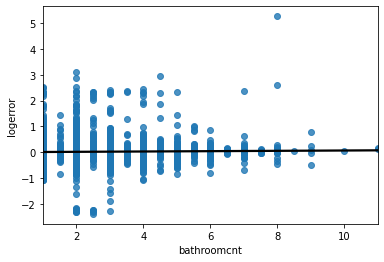

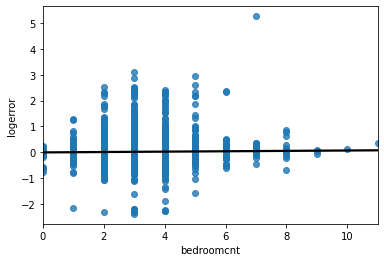

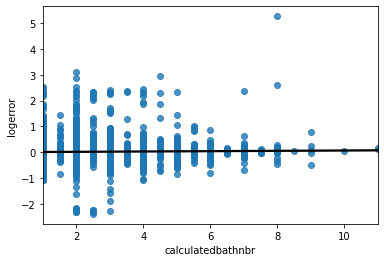

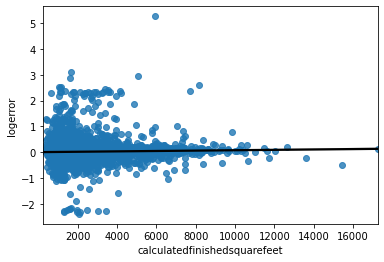

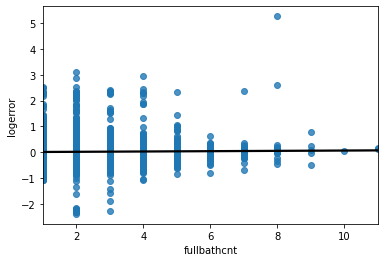

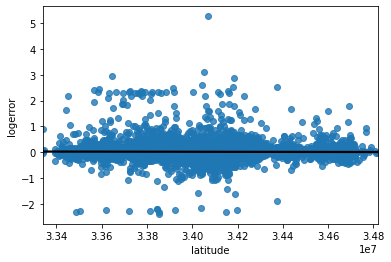

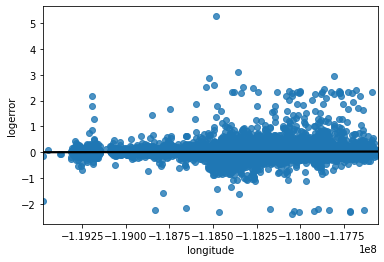

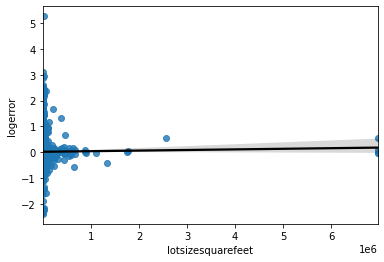

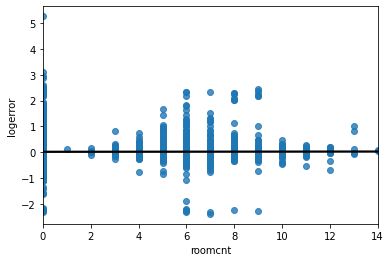

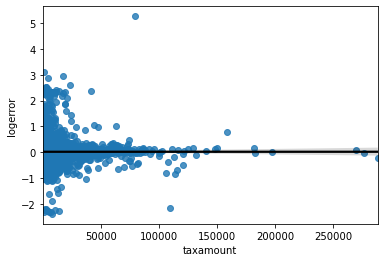

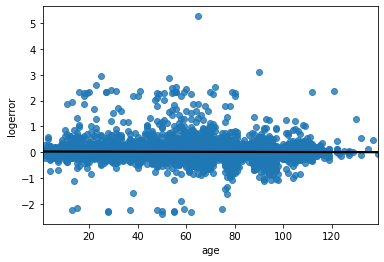

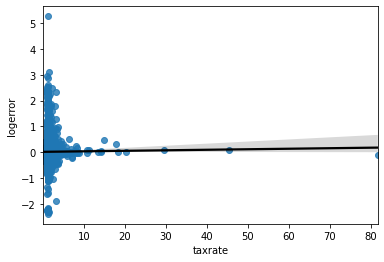

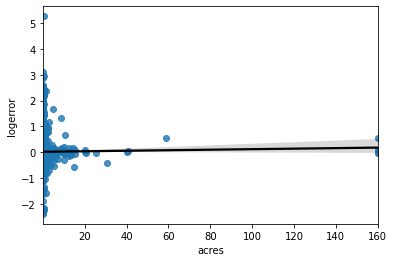

In [7]:
explore.plot_vars_target(train, 'logerror', variables)

#### Univariate Takeaways:
- The widest range of logerror appears to be on lower-middle class properties
    - most variables have widest range of logerror at lower end of variable range
    - bed, bath, sqft, etc have greatest error at their respective lower ends
- I would like to be able to use latitude and longitude to create neighborhood variables
- Plenty of exploration still left to do, and no clear cut drivers of error at this point...

## Hypothosis Testing

### Hypothesis 1:
- ${H_O}$: There is no difference in mean logerror between bathroomcnt <=1, and mean logerror of all bathroom counts.
- ${H_a}$: There is a difference in mean logerror between bathroomcnt <=1, and mean logerror of all bathroom counts.
- alpha = 0.05

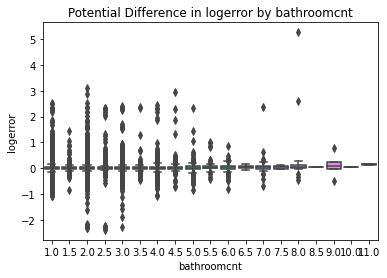

In [8]:
sns.boxplot(train.bathroomcnt, train.logerror)
plt.title('Potential Difference in logerror by bathroomcnt')
plt.show()

In [9]:
# How does variance compare among these groups?
stats.levene(train[train.bathroomcnt<=1].logerror, train[train.bathroomcnt>1].logerror)

LeveneResult(statistic=105.24965325419026, pvalue=1.1863046321968556e-24)

In [10]:
# Now to run a ttest to compare mean logerrors
stats.ttest_ind(train[train.bathroomcnt <= 1].logerror, train[train.bathroomcnt > 1].logerror, equal_var=False)

Ttest_indResult(statistic=-0.7012325064809944, pvalue=0.4831803460836652)

#### Hypothesis 1 Takeaways:
- Due to leven test, we see vairance is not equal among these groups
- Since my p-value is greater than alpha, we fail to reject the null hypothesis

### Hypothesis 2:
- ${H_O}$: There is no difference in mean logerror between bedroomcnt <=3, and mean logerror of bedroomcnt > 3.
- ${H_a}$: There is a difference in mean logerror between bedroomcnt <=3, and mean logerror of bedroomcnt > 3.
- alpha = 0.05

In [11]:
# How does variance compare among these groups?
stats.levene(train[train.bedroomcnt<=1].logerror, train[train.bedroomcnt>1].logerror)

LeveneResult(statistic=33.385324554907676, pvalue=7.636330763759084e-09)

In [12]:
# Now to run a ttest to compare mean logerrors
stats.ttest_ind(train[train.bedroomcnt <= 3].logerror, train[train.bedroomcnt > 3].logerror, equal_var=False)

Ttest_indResult(statistic=-4.916098061787841, pvalue=8.88965221676961e-07)

#### Hypothesis 2 Takeaways:
- Due to Levene test, we see vairance is not equal among these groups
- Since my p-value is less than alpha, we can reject the null hypothesis
- Evidence to suggest bedroomcnt could be a good feature for modeling

### Hypothesis 3:
- ${H_O}$: There is no relationship between latitude and logerror, (they are independent variables.)
- ${H_a}$: There is a relationship between latitude and logerror, (they are dependent variables.)
- alpha = 0.05

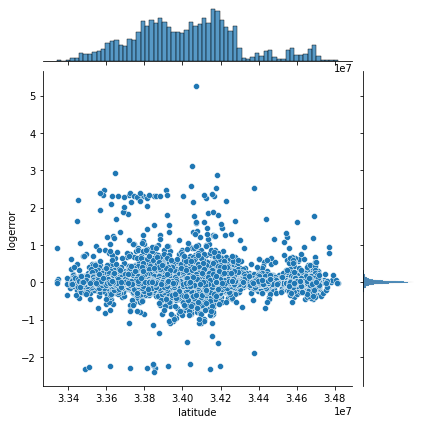

In [13]:
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Latitude')
plt.ylabel('Logerror')
plt.show()

In [14]:
r, p = stats.pearsonr(train.latitude, train.logerror)
r, p

(-0.018422437215925836, 0.0016856921851585583)

#### Hypothesis 3 Takeaways:
- Since my p-value is less than alpha, we can reject the null hypothesis
- However, due to a very low correlation coefficient (r), there does not appear to be evidence to suggest linear relationship between latitude and logerror
- Evidence to suggest latitude could be a good feature for modeling, if used in conjunction with other features

### Hypothesis 4:
- ${H_O}$: There is no relationship between longitude and logerror, (they are independent variables.)
- ${H_a}$: There is a relationship between longitude and logerror, (they are dependent variables.)
- alpha = 0.05

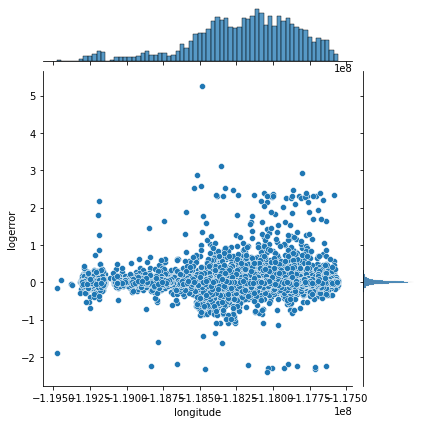

In [15]:
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Logerror')
plt.show()

In [16]:
r, p = stats.pearsonr(train.longitude, train.logerror)
r, p

(0.028327842315193134, 1.3660843125859253e-06)

#### Hypothesis 4 Takeaways:
- Since my p-value is less than alpha, we can reject the null hypothesis
- However, due to a very low correlation coefficient (r), there does not appear to be evidence to suggest linear relationship between longitude and logerror
- Evidence to suggest longitude could be a good feature for modeling, if used in conjunction with other features

### Data Clustering:

In [17]:
# scale my data...
train_scaled, \
validate_scaled, \
test_scaled = explore.Standard_Scaler(train, validate, test)

In [18]:
X_train_scaled = train_scaled.drop(columns='logerror')
X_validate_scaled = validate_scaled.drop(columns='logerror')
X_test_scaled = test_scaled.drop(columns='logerror')

In [19]:
y_train_scaled = train_scaled['logerror']
y_validate_scaled = validate_scaled['logerror']
y_test_scaled = test_scaled['logerror']

#### cluster_alpha

In [20]:
X0_train = X_train[['age', 'latitude', 'longitude']]
X0_train_scaled, stan_scaler = explore.scale_my_data(X0_train, StandardScaler())

X0_validate = X_validate[['age', 'latitude', 'longitude']]
X0_validate_scaled, stan_scaler = explore.scale_my_data(X0_validate, StandardScaler())

X0_test = X_test[['age', 'latitude', 'longitude']]
X0_test_scaled, stan_scaler = explore.scale_my_data(X0_test, StandardScaler())

In [21]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=3, random_state = 1221)

# fit the thing
kmeans.fit(X0_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X0_train_scaled)

array([0, 0, 0, ..., 2, 2, 1], dtype=int32)

In [22]:
# make a new column names cluster in train_scaled and X_train_scaled dataframe
# make a new column names cluster in iris and X_scaled dataframe
train_scaled['cluster_alpha'] = kmeans.predict(X0_train_scaled)

X_train_scaled['cluster_alpha'] = kmeans.predict(X0_train_scaled)
X_validate_scaled['cluster_alpha'] = kmeans.predict(X0_validate_scaled)
X_test_scaled['cluster_alpha'] = kmeans.predict(X0_test_scaled)

In [23]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X0_train.columns)
centroids_scaled

,age,latitude,longitude
0,0.824922,-0.038118,-0.042102
1,-0.625765,-0.966321,0.946969
2,-0.656056,1.197281,-1.039438


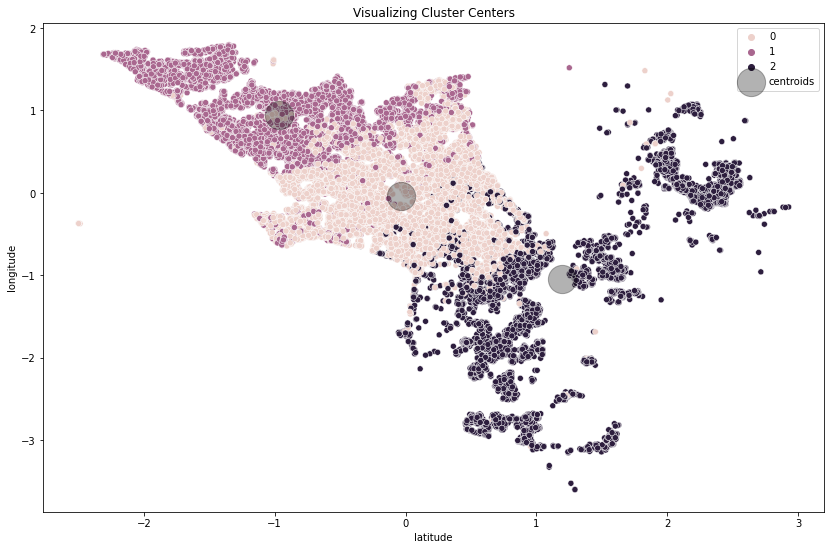

In [24]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'latitude', y = 'longitude', data = X_train_scaled, hue = 'cluster_alpha')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'latitude', y = 'longitude', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

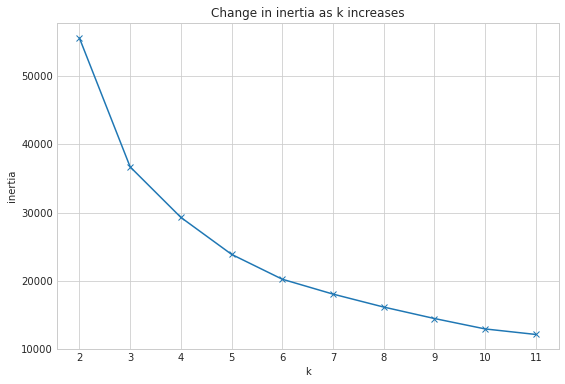

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X0_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

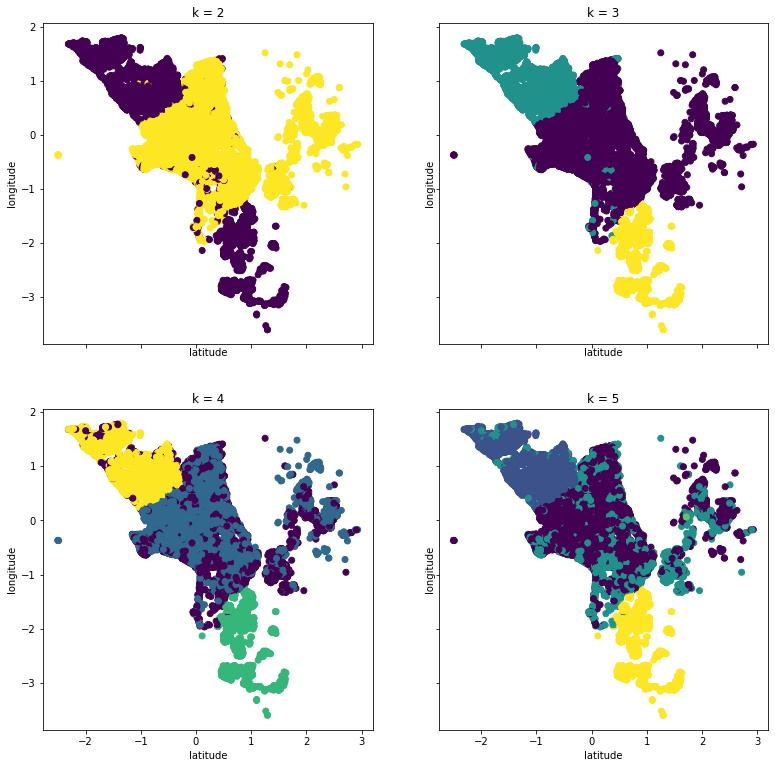

In [26]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_train_scaled).predict(X_train_scaled)
    ax.scatter(X_train_scaled.latitude, X_train_scaled.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

In [27]:
# create subsets for clusters
alpha_0 = train_scaled[train_scaled.cluster_alpha == 0].logerror
alpha_1 = train_scaled[train_scaled.cluster_alpha == 1].logerror
alpha_2 = train_scaled[train_scaled.cluster_alpha == 2].logerror

In [28]:
X_train_scaled['cluster_alpha'] = kmeans.predict(X0_train_scaled)
X_validate_scaled['cluster_alpha'] = kmeans.predict(X0_validate_scaled)
X_test_scaled['cluster_alpha'] = kmeans.predict(X0_test_scaled)

In [29]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(alpha_0, alpha_1, alpha_2)
f, p

(19.24708666516382, 4.432290868330314e-09)

In [30]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Can reject the null hypothesis that the logerror is the same across all 3 clusters.
There is evidence to support that the logerror is different in the clusters.


#### cluster_alpha takeways:
- 3 or 4 clusters appears to be the way to go...
- While intertia is lower on 4 clusters, 3 might provide less overfitting
- Both (3,4) are worth exploring further...

#### cluster_bravo

In [31]:
X1_train = train[['calculatedfinishedsquarefeet', 'age']]
X1_train_scaled, stan_scaler = explore.scale_my_data(X1_train, StandardScaler())

X1_validate = validate[['calculatedfinishedsquarefeet', 'age']]
X1_validate_scaled, stan_scaler = explore.scale_my_data(X1_validate, StandardScaler())

X1_test = test[['calculatedfinishedsquarefeet', 'age']]
X1_test_scaled, stan_scaler = explore.scale_my_data(X1_test, StandardScaler())

In [32]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=4, random_state = 1221)

# fit the thing
kmeans.fit(X1_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X1_train_scaled)

array([3, 0, 0, ..., 0, 0, 2], dtype=int32)

In [33]:
# make a new column names cluster in iris and X_scaled dataframe
train_scaled['cluster_bravo'] = kmeans.predict(X1_train_scaled)

X_train_scaled['cluster_bravo'] = kmeans.predict(X1_train_scaled)
X_validate_scaled['cluster_bravo'] = kmeans.predict(X1_validate_scaled)
X_test_scaled['cluster_bravo'] = kmeans.predict(X1_test_scaled)

In [34]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X1_train.columns)
centroids_scaled

,calculatedfinishedsquarefeet,age
0,-0.413788,0.244212
1,2.623524,-1.038707
2,0.374229,-1.043638
3,-0.468067,1.531131


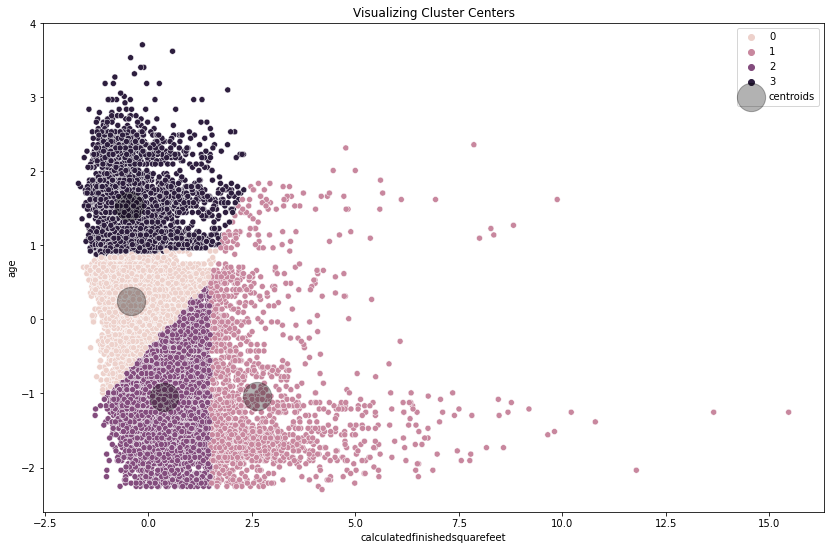

In [35]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'age', data = X_train_scaled, hue = 'cluster_bravo')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'calculatedfinishedsquarefeet', y = 'age', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

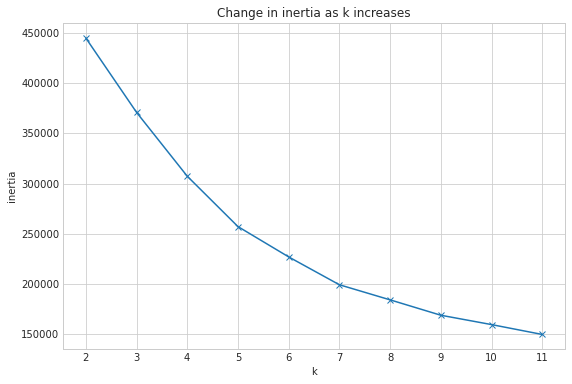

In [36]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

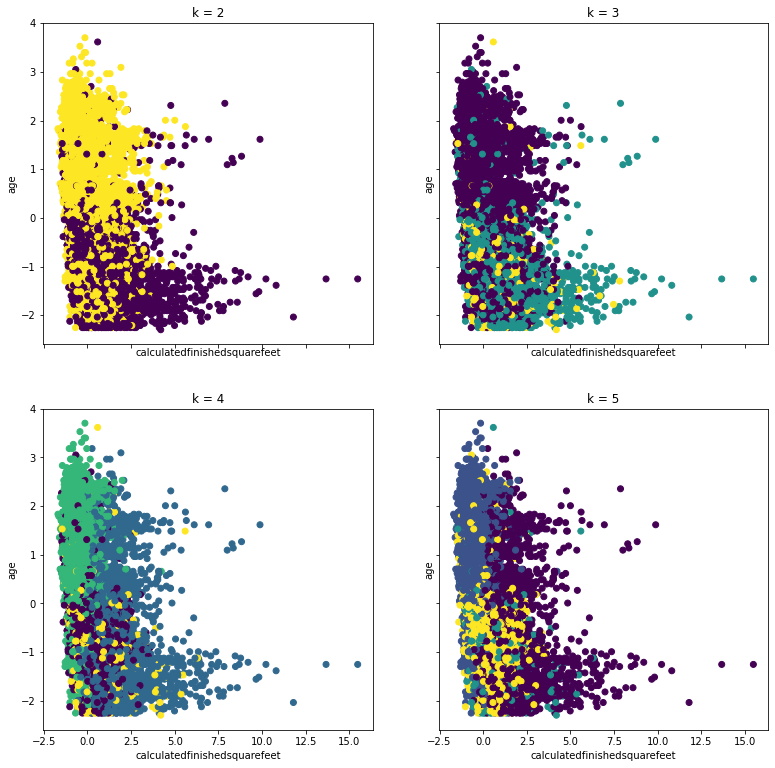

In [37]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_train_scaled).predict(X_train_scaled)
    ax.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='calculatedfinishedsquarefeet', ylabel='age')

In [38]:
# create subsets for clusters
bravo_0 = train_scaled[train_scaled.cluster_bravo == 0].logerror
bravo_1 = train_scaled[train_scaled.cluster_bravo == 1].logerror
bravo_2 = train_scaled[train_scaled.cluster_bravo == 2].logerror
bravo_3 = train_scaled[train_scaled.cluster_bravo == 3].logerror

In [39]:
X_train_scaled['cluster_bravo'] = kmeans.predict(X1_train_scaled)
X_validate_scaled['cluster_bravo'] = kmeans.predict(X1_validate_scaled)
X_test_scaled['cluster_bravo'] = kmeans.predict(X1_test_scaled)

In [40]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 4 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(bravo_0, bravo_1, bravo_2)
f, p

(19.28347169658253, 4.284101652526908e-09)

In [41]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Can reject the null hypothesis that the logerror is the same across all 4 clusters.
There is evidence to support that the logerror is different in the clusters.


#### cluster_bravo takeways:
- 3 or 4 clusters appears to be the way to go...
- although 5 is interesting as well (might be overfit, might be great...)
- 3, 4, and 5 all worth exploring further on beta

#### cluster_charlie

In [42]:
X2_train = train[['bedroomcnt', 'bathroomcnt', 'taxrate']]
X2_train_scaled, stan_scaler = explore.scale_my_data(X2_train, StandardScaler())

X2_validate = validate[['bedroomcnt', 'bathroomcnt', 'taxrate']]
X2_validate_scaled, stan_scaler = explore.scale_my_data(X2_validate, StandardScaler())

X2_test = test[['bedroomcnt', 'bathroomcnt', 'taxrate']]
X2_test_scaled, stan_scaler = explore.scale_my_data(X2_test, StandardScaler())

In [43]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=3, random_state = 1221)

# fit the thing
kmeans.fit(X2_train_scaled)

# Use (predict using) the thing 
kmeans.predict(X2_train_scaled)

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

In [44]:
# make a new column names cluster in train_scaled and X_train_scaled dataframe
train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)

X_train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)
X_validate_scaled['cluster_charlie'] = kmeans.predict(X2_validate_scaled)
X_test_scaled['cluster_charlie'] = kmeans.predict(X2_test_scaled)

In [45]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X2_train.columns)
centroids_scaled

,bedroomcnt,bathroomcnt,taxrate
0,1.010197,0.726617,-0.080179
1,-0.637510,-0.458583,0.038548
2,-0.686814,-0.294265,71.612987


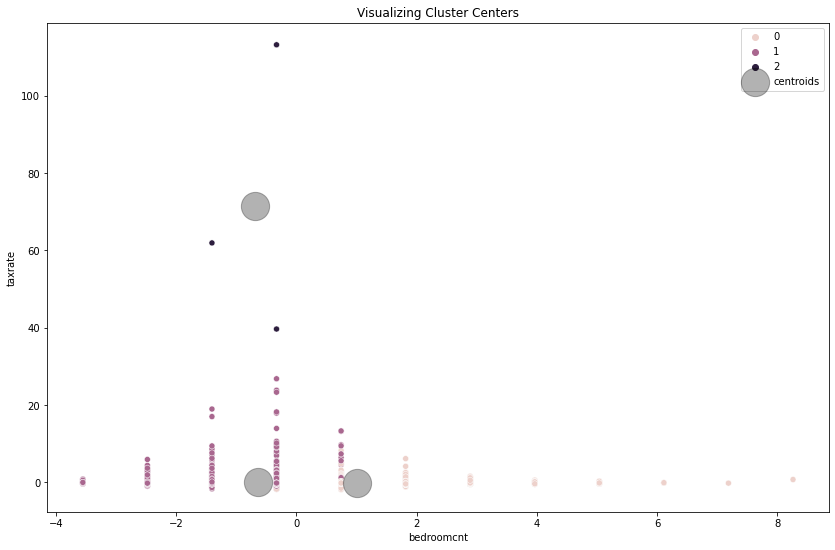

In [46]:
# lets visualize the clusters along with the centers on scaled data.

plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'bedroomcnt', y = 'taxrate', data = X_train_scaled, hue = 'cluster_charlie')

# plot cluster centers (centroids)
centroids_scaled.plot.scatter(x= 'bedroomcnt', y = 'taxrate', 
                              ax = plt.gca(), 
                              s = 800, color = 'k', 
                              alpha = 0.3, 
                              label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

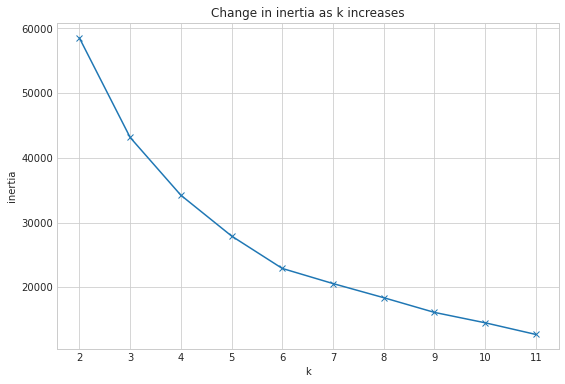

In [47]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

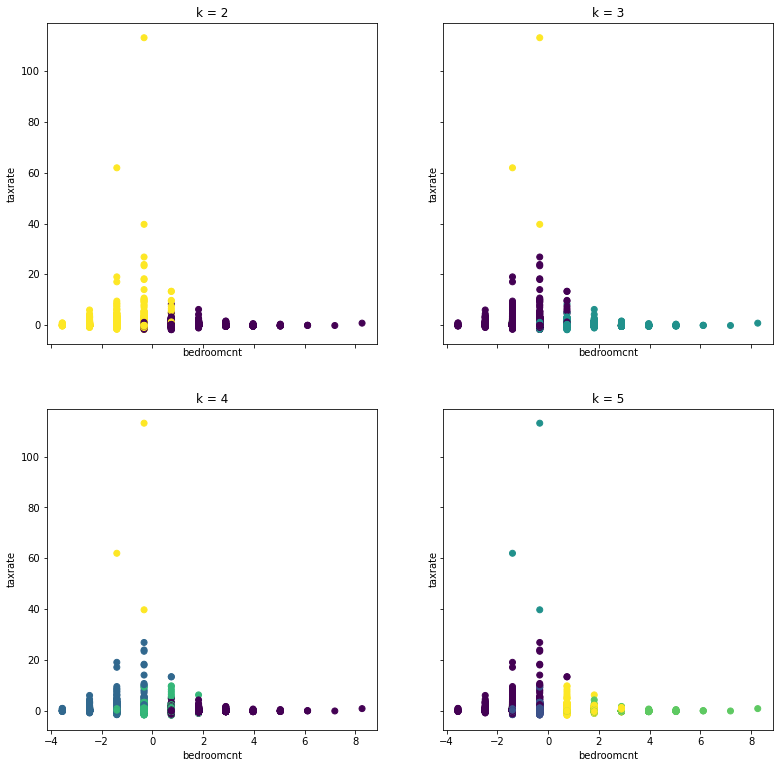

In [48]:
# What value of k is appropriate?


fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X2_train_scaled).predict(X2_train_scaled)
    ax.scatter(X2_train_scaled.bedroomcnt, X2_train_scaled.taxrate, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='bedroomcnt', ylabel='taxrate')

In [49]:
# create subsets for clusters
charlie_0 = train_scaled[train_scaled.cluster_charlie == 0].logerror
charlie_1 = train_scaled[train_scaled.cluster_charlie == 1].logerror
charlie_2 = train_scaled[train_scaled.cluster_charlie == 2].logerror

In [50]:
X_train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)
X_validate_scaled['cluster_charlie'] = kmeans.predict(X2_validate_scaled)
X_test_scaled['cluster_charlie'] = kmeans.predict(X2_test_scaled)

In [51]:
# run ANOVA test to determine if logerror is equal across all clusters
null_hypothesis = 'the logerror is the same across all 3 clusters.'
alt_hypothesis = 'the logerror is different in the clusters.'

alpha = 0.05

f, p = stats.f_oneway(charlie_0, charlie_1, charlie_2)
f, p

(13.578868245881134, 1.2750479639007745e-06)

In [52]:
if p < alpha:
    print('Can reject the null hypothesis that', null_hypothesis)
    print('There is evidence to support that', alt_hypothesis)
else:
    print('Fail to reject the null hypothesis.')
    print('There is evidence to support that', null_hypothesis)

Can reject the null hypothesis that the logerror is the same across all 3 clusters.
There is evidence to support that the logerror is different in the clusters.


#### cluster_charlie takeways:
- 3 or 4 clusters appears to be the way to go...
- looks like 4 gives the best groupings

In [53]:
# create dummies for bbratio_value_cluster and merge to subsets
dummy_df = pd.get_dummies(X_train_scaled.cluster_alpha, prefix='cluster_alpha')
X_train_scaled = pd.concat([X_train_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_validate_scaled.cluster_alpha, prefix='cluster_alpha')
X_validate_scaled = pd.concat([X_validate_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_test_scaled.cluster_alpha, prefix='cluster_alpha')
X_test_scaled = pd.concat([X_test_scaled, dummy_df], axis=1)

In [54]:
# create dummies for bbratio_value_cluster and merge to subsets
dummy_df = pd.get_dummies(X_train_scaled.cluster_bravo, prefix='cluster_bravo')
X_train_scaled = pd.concat([X_train_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_validate_scaled.cluster_bravo, prefix='cluster_bravo')
X_validate_scaled = pd.concat([X_validate_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_test_scaled.cluster_bravo, prefix='cluster_bravo')
X_test_scaled = pd.concat([X_test_scaled, dummy_df], axis=1)

In [55]:
# create dummies for bbratio_value_cluster and merge to subsets
dummy_df = pd.get_dummies(X_train_scaled.cluster_charlie, prefix='cluster_charlie')
X_train_scaled = pd.concat([X_train_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_validate_scaled.cluster_charlie, prefix='cluster_charlie')
X_validate_scaled = pd.concat([X_validate_scaled, dummy_df], axis=1)
dummy_df = pd.get_dummies(X_test_scaled.cluster_charlie, prefix='cluster_charlie')
X_test_scaled = pd.concat([X_test_scaled, dummy_df], axis=1)

In [56]:
X_train_scaled = X_train_scaled.drop(columns=['cluster_alpha', 'cluster_bravo', 'cluster_charlie'])
X_validate_scaled = X_validate_scaled.drop(columns=['cluster_alpha', 'cluster_bravo', 'cluster_charlie'])
X_test_scaled = X_test_scaled.drop(columns=['cluster_alpha', 'cluster_bravo', 'cluster_charlie'])

### Data Modeling

In [57]:
# let's find the baseline logerror...
train_scaled.logerror.mean()

-1.0679702919168731e-17

In [58]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_test_scaled = pd.DataFrame(y_test_scaled)

# Predict av_pred_mean
av_pred_mean = y_train_scaled['logerror'].mean()
y_train_scaled['baseline'] = av_pred_mean
y_validate_scaled['baseline'] = av_pred_mean
y_test_scaled['baseline'] = av_pred_mean

# RMSE of av_pred_mean
rmse_train = mean_squared_error(y_train_scaled['logerror'], y_train_scaled['baseline']) ** 0.5
rmse_validate = mean_squared_error(y_validate_scaled['logerror'], y_validate_scaled['baseline']) ** 0.5

# How did the baseline mean perform
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

RMSE using Mean
Train/In-Sample:  1.0 
Validate/Out-of-Sample:  1.0703


In [64]:
# Clean it up now
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate.round(4),
    'r^2_validate': explained_variance_score(y_validate_scaled['logerror'], y_validate_scaled['baseline'])}])
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,1.0703,0.0


In [65]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train_scaled['logerror'])

# predict train
y_train_scaled['baseline'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled['logerror'], y_train_scaled['baseline']) ** (1/2)
# predict validate
y_validate_scaled['baseline'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled['logerror'], y_validate_scaled['baseline']) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 27 is different from 26)

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['logerror'], y_validate['baseline'])}, ignore_index=True)
metric_df

In [ ]:
# use RFE to find best cluster for analysis
X = X_train_scaled
y = train['logerror']

lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=4)
rfe.fit(X, y)

pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

In [ ]:
X_train_scaled.cluster_charlie_0.value_counts()

In [ ]:
X_train_scaled.cluster_charlie_1.value_counts()

In [ ]:
X_train_scaled.cluster_charlie_2.value_counts()

In [ ]:
X_train_scaled.shape

In [ ]:

# make feature list using top property features - with the clusters
X1_cols = ['cluster_charlie_1', 'cluster_charlie_0', 'cluster_bravo_3']

X_train_1 = X_train_scaled[X1_cols]
X_validate_1 = X_validate_scaled[X1_cols]
X_test_1 = X_test_scaled[X1_cols]

In [ ]:
# model2 using top property features list AND 'clusters'
#create the model
model2 = LinearRegression(normalize=True)
# fit the model
model2.fit(X_train_1, y_train.logerror)
# use the model to make predictions
y_train['model2'] = model2.predict(X_train_1)
y_validate['model2'] = model2.predict(X_validate_1)
# evaluate the results
print('Train RMSE for model2:', math.sqrt(mean_squared_error(y_train.logerror, y_train.model2)))
rmse_model2 = math.sqrt(mean_squared_error(y_validate.logerror, y_validate.model2))
print('Validate RMSE model2:', rmse_model2)

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 2',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate['logerror'], y_validate['baseline'])}, ignore_index=True)
metric_df

#### LassoLars

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train['appraised_value'])

# predict train
y_train['av_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train['appraised_value'], y_train['av_pred_lars']) ** 0.5

# predict validate
y_validate['av_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['appraised_value'], y_validate['av_pred_lars']) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)